# Business Understanding: NBA Last 2 Minute Analysis

Over the years, the relationship between the referees and the players in the National Basketball Association (NBA) has come to impasse. The players and coaches believe the referees are affecting the outcome of the games and showing bias. Players and coaches’ sentiment have also reached into the fan base where the fans are taking issues on how the games are being called by the referees. The NBA decided to implement the last two-minute report to help protect the integrity of the game. This report provides an assessment of officiated events that occurred in the last two minutes for every game that were at or within three points during any points of the last two minutes of the fourth quarter and overtime. The plays assessed include all calls and all notable non calls. Non calls are defined as material plays directly related to the outcome of a possession. This report was the NBA's first step to total transparency. The main outcome that the NBA is concerned with is whether the referees got the call right in the realms of the rules. 

Our teams's analysis will focus on determining whether there is bias towards particular players or teams for referee calls during the previously mentioned last two minutes. We will be augmenting our base data set with additional attributes indicating whethere a player's status is all-star or not. Are all-star players treated differently? Do officials have a tendency to get more calls right or wrong when it comes to all-star players? Answering these questions can help with training and teaching of referees of their biases.

In [163]:
# Import initial libraries 
import numpy as np
import pandas as pd

# show all columns with .head()
pd.set_option('display.max_columns', None)

# Visulization libraries
import matplotlib as plt
%matplotlib inline
import seaborn as sns

import warnings 
warnings.simplefilter('ignore', DeprecationWarning)

# Data Meaning Type 

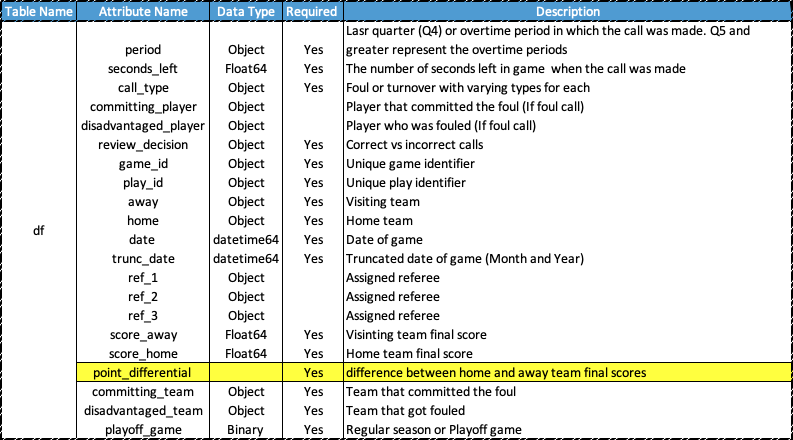

We determined some variables were not needed for this analysis so they were elimnated before subsequent data wrangling efforts.
- **time**: time of call or non call, will use seconds remained column instead
- **video**: web link to a video of call or non call, not relevant to analysis
- **original_pdf**: pdf file name, not relevant to analysis
- **box_score_url**: url, scores are already in separate columns
- **comment**: text describing the violation, we will not be performing any NLP in this analysis
- **ref_made_call**: names only exist in 0.8% of the data, will use columns indicating refs that officiated the game

In [164]:
# Import data
df = pd.read_csv("data/all_games.csv")

print (df.info())

# drop unecessary columns 
df = df.drop(columns=['time','video','original_pdf','box_score_url','comment','ref_made_call'], axis=1)

#df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26822 entries, 0 to 26821
Data columns (total 35 columns):
Index                   26822 non-null int64
period                  26822 non-null object
time                    26822 non-null float64
seconds_left            26822 non-null float64
call_type               26821 non-null object
committing_player       25377 non-null object
disadvantaged_player    22455 non-null object
review_decision         25101 non-null object
comment                 26822 non-null object
video                   26760 non-null object
game_id                 26822 non-null object
play_id                 26822 non-null object
away                    26822 non-null object
home                    26822 non-null object
date                    26822 non-null int64
ref_1                   26767 non-null object
ref_2                   26767 non-null object
ref_3                   26687 non-null object
score_away              26786 non-null float64
score_home      

In [165]:
df.head()

,Index,period,seconds_left,call_type,committing_player,disadvantaged_player,review_decision,game_id,play_id,away,home,date,ref_1,ref_2,ref_3,score_away,score_home,disadvantaged_team,committing_team,Foul,Instant Replay,Other,Turnover,Violation,OT,10Sec,allstar,c_playerid,d_playerid
0,10000,Q4,112.0,Foul: Shooting,Josh Smith,Kevin Love,CNC,20150301CLEHOU,20150301CLEHOU-0,CLE,HOU,20150301,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,2746.0,201567.0
1,10001,Q4,103.0,Foul: Shooting,J.R. Smith,James Harden,CC,20150301CLEHOU,20150301CLEHOU-1,CLE,HOU,20150301,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,0,0,0,2747.0,201935.0
2,10002,Q4,92.0,Foul: Shooting,Trevor Ariza,LeBron James,CC,20150301CLEHOU,20150301CLEHOU-2,CLE,HOU,20150301,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,2772.0,2544.0
3,10003,Q4,69.0,Foul: Loose Ball,Terrence Jones,Tristan Thompson,CC,20150301CLEHOU,20150301CLEHOU-3,CLE,HOU,20150301,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,203093.0,202684.0
4,10004,Q4,53.0,Foul: Shooting,Tristan Thompson,Josh Smith,CNC,20150301CLEHOU,20150301CLEHOU-4,CLE,HOU,20150301,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,0,0,0,202684.0,2746.0


Our initial dataset has a total of 26,822 records with 18 attributes. 

In [166]:
df.shape

(26822, 29)

# Data Quality

Let's check the uniqueness of the **review_decision** field. We expect to see only the following codes: 
- CC = correct call 
- CNC = correct non-call
- IC = incorrect call
- INC = incorrect non-call.

There are 44 records with player names misplaced, so the team decided to remove them altogether given the represent such a small percentage of the total dataset. 

In [167]:
# Check valid unique values per column
df.groupby('review_decision')['review_decision'].count().sort_values(ascending=False)

review_decision
CNC                 15448
CC                   7412
INC                  1957
IC                    240
Damian Lillard          6
Ricky Rubio             4
Marcin Gortat           4
Bradley Beal            3
Mario Chalmers          3
Terrence Ross           3
Thabo Sefolosha         2
Jerryd Bayless          2
CJ McCollum             2
Jonathon Simmons        2
Marc Gasol              2
Nikola Vucevic          2
Ben Simmons             2
Joe Ingles              1
JJ Redick               1
Jusuf Nurkic            1
Kelly Oubre Jr.         1
Maurice Harkless        1
Robert Covington        1
Shelvin Mack            1
Name: review_decision, dtype: int64

There seem to be some invalid values in the 'period' column as well. For example, this column should only contain values Q4 and great, but there is a value listed as 'Q3'. This doesn't make sense given this data is from the 2 minute report. There are only 2 records affected so we decided to remove them from our dataset. Anything greater than Q4 is overtime.

In [168]:
df.groupby('period')['period'].count().sort_values(ascending=False)

period
Q4    22488
Q5     3831
Q6      409
Q7       56
Q8       36
Q3        2
Name: period, dtype: int64

In [169]:
# Remove invalid rows that show player names in the review_decision column
df = df.loc[(df['review_decision']=='CNC') | (df['review_decision']=='CC') | (df['review_decision']=='INC')
      | (df['review_decision']=='IC')]

# remove the rows that do not include valid values for the review_decision column, create df2 with results
# df = df[df.review_decision.isin([x for x in df.review_decision if x in ['CC','CNC','IC','INC']])]

# Remove invalid Q3 rows from period column. Final 2 min report should not include plays in the 3rd quarter 
df = df[df.period != 'Q3']

Let's check to ensure the incorrect values were indeed removed.

In [170]:
print(df.groupby('review_decision')['review_decision'].count())

review_decision
CC      7412
CNC    15446
IC       240
INC     1957
Name: review_decision, dtype: int64


In [171]:
print(df.groupby('period')['period'].count())

period
Q4    20956
Q5     3630
Q6      382
Q7       54
Q8       33
Name: period, dtype: int64


#### NaN Check

The "disadvantaged_player" column has the majority of missing values in this dataframe. We know that not all of these entries are fouls so it would make sense there are no "committing_team", "disadvantaged_team", "committing_player" or "disadvantaged_player" in some instances. However, there should always be at least 1 referee per contest. Let's dig deeper...

In [172]:
# Missing values sort descending
df_percent = df.isna().sum()/len(df)*100 # Percent of total 'NaN' rows by column
df_percent.sort_values(ascending=False)

d_playerid              11.766115
disadvantaged_player    11.754141
committing_team          5.986829
disadvantaged_team       5.986829
c_playerid               5.523848
committing_player        5.491918
ref_3                    0.498902
ref_2                    0.207543
ref_1                    0.207543
score_home               0.131710
score_away               0.131710
Other                    0.000000
play_id                  0.000000
period                   0.000000
seconds_left             0.000000
call_type                0.000000
allstar                  0.000000
10Sec                    0.000000
review_decision          0.000000
game_id                  0.000000
home                     0.000000
away                     0.000000
Instant Replay           0.000000
date                     0.000000
OT                       0.000000
Violation                0.000000
Turnover                 0.000000
Foul                     0.000000
Index                    0.000000
dtype: float64

xxxxxxxx

In [173]:
df_NoNaN = df.dropna(subset=['ref_1','ref_2','ref_3'], thresh=1) 

In [175]:
# Create new dataframe with NaN rows removed
# Only remove NA values that are in the columns listed in the subset. If at least 1 NaN then remove
# Still need to handle ref_1, ref_2, ref_3 columns differently. Delete rows if all 3 ref columns are missing 
df_NoNaN = df.dropna(subset=['disadvantaged_player','review_decision','committing_player',
                            'score_home','score_away','call_type']) 

# comparing NEW (df) vs OLD (df2) dataframes 
#print("Old data frame length:", len(df), "\nNew data frame length:",  
#      len(df_NoNaN), "\nNumber of rows with at least 1 NA value: ", 
#       (len(df)-len(df_NoNaN)),"\nPercent of total rows lost to NA values:",
#     (len(df)-len(df_NoNaN))/len(df))

# comparing NEW (df) vs OLD (df2) dataframes 
print("Old data frame length:", len(df))
print("New data frame length:",len(df_NoNaN))
print("Number of rows with at least 1 NA value: ",len(df)-len(df_NoNaN))
print("Percent of total rows lost to NA values: {0:.2f}%".format(100*(len(df)-len(df_NoNaN))/len(df)))

Old data frame length: 25055
New data frame length: 22081
Number of rows with at least 1 NA value:  2974
Percent of total rows lost to NA values: 11.87%


In [176]:
df = df_NoNaN

# New Features

We will identify new features here and perform simple statistics on all features later.

#### Point Differential

There may be value in creating a point differential column between the home and away scores allowing us to potentially reduce the number of variables in our dataset. We won't know for sure until we investigate further, but we will add it  to our dataframe in advance. 

In [177]:
df['point_diff'] = df['score_home']-df['score_away']

#### Date Transformation/Fields

There may be value in using the date column to explore our data and look at things like referee performance over time and other trended insights. In order to do this we must convert the date field from from a integer variable type to datetime so we may access date attributes in subsequent analysis.

In [178]:
# Add some date functions

# Convert date from int64 to datetime column
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d', errors='raise')

# Truncate date to represent month and year only
df['trunc_date'] = df['date'].values.astype('datetime64[M]')

# Create month and year column as string
df['month_year'] = df['date'].dt.to_period('M')

#### Review Decision - Numeric Codes

Next we will create code mappings for the review_decision field. CC  = 0, CNC = 1, IC = 2, INC = 3

In [180]:
# create new column of coded review_decisions
df['review_decision_code']=df.review_decision.astype("category").cat.codes

#### Field for Good and Bad Calls
This field creates a variable where the two types of good and bad calls are combined. 
- CC and CNC = good call = 1
- IC and INC = bad call = 0

In [181]:
# add a column for good/bads calls where (CC & CNC) = 1, bad calls (IC & INC) = 0
df['good_bad'] = np.where((df['review_decision']=='CC') | (df['review_decision']=='CNC'), 1, 0)

#### Indicator For Visitor Getting a Bad Call
Let's create a field to obtain insights on whether their is bias towards the visiting team.

In [183]:
# add a column indicating if the visiting team got a bad call, yes = 1, no = 0
df['disadv_visitor'] = np.where((df['disadvantaged_team'] == df['away']) & (df['good_bad']== 0), 1, 0)

In [184]:
df.head(100)

,Index,period,seconds_left,call_type,committing_player,disadvantaged_player,review_decision,game_id,play_id,away,home,date,ref_1,ref_2,ref_3,score_away,score_home,disadvantaged_team,committing_team,Foul,Instant Replay,Other,Turnover,Violation,OT,10Sec,allstar,c_playerid,d_playerid,point_diff,trunc_date,month_year,review_decision_code,good_bad,disadv_visitor
0,10000,Q4,112.0,Foul: Shooting,Josh Smith,Kevin Love,CNC,20150301CLEHOU,20150301CLEHOU-0,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,2746.0,201567.0,2.0,2015-03-01,2015-03,1,1,0
1,10001,Q4,103.0,Foul: Shooting,J.R. Smith,James Harden,CC,20150301CLEHOU,20150301CLEHOU-1,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,0,0,0,2747.0,201935.0,2.0,2015-03-01,2015-03,0,1,0
2,10002,Q4,92.0,Foul: Shooting,Trevor Ariza,LeBron James,CC,20150301CLEHOU,20150301CLEHOU-2,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,2772.0,2544.0,2.0,2015-03-01,2015-03,0,1,0
3,10003,Q4,69.0,Foul: Loose Ball,Terrence Jones,Tristan Thompson,CC,20150301CLEHOU,20150301CLEHOU-3,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,203093.0,202684.0,2.0,2015-03-01,2015-03,0,1,0
4,10004,Q4,53.0,Foul: Shooting,Tristan Thompson,Josh Smith,CNC,20150301CLEHOU,20150301CLEHOU-4,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,0,0,0,202684.0,2746.0,2.0,2015-03-01,2015-03,1,1,0
5,10005,Q4,29.1,Foul: Shooting,Terrence Jones,LeBron James,CNC,20150301CLEHOU,20150301CLEHOU-5,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,203093.0,2544.0,2.0,2015-03-01,2015-03,1,1,0
6,10006,Q5,274.0,Foul: Shooting,Tristan Thompson,Terrence Jones,CC,20150301CLEHOU,20150301CLEHOU-6,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,1,0,0,202684.0,203093.0,2.0,2015-03-01,2015-03,0,1,0
8,10008,Q5,245.0,Foul: Personal,LeBron James,James Harden,CNC,20150301CLEHOU,20150301CLEHOU-8,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,1,0,1,2544.0,201935.0,2.0,2015-03-01,2015-03,1,1,0
9,10009,Q5,234.0,Foul: Double Personal,LeBron James,James Harden,INC,20150301CLEHOU,20150301CLEHOU-9,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,1,0,1,2544.0,201935.0,2.0,2015-03-01,2015-03,3,0,0
10,10010,Q5,171.0,Foul: Shooting,Josh Smith,LeBron James,CNC,20150301CLEHOU,20150301CLEHOU-10,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,1,0,0,2746.0,2544.0,2.0,2015-03-01,2015-03,1,1,0


In [185]:
# *** USE FOR DEBUGGING ***
# print dataframe to a temp CSV file, for specified columns to cross-check
#df.to_csv('tmp.csv', columns = ['good_bad','away','disadvantaged_team','disadv_visitor'])

#### Game Type (Regular Season vs Post Season)
Let's create an indicator for regular season games vs post season games.

In [188]:
# add a column for game type where regular season = 1, post season = 2

# create playoff date range
playoff_start2015=pd.to_datetime('2015-4-18', format='%Y-%m-%d', errors='raise')
playoff_stop2015=pd.to_datetime('2015-06-16', format='%Y-%m-%d', errors='raise')
playoff_start2016=pd.to_datetime('2016-4-16', format='%Y-%m-%d', errors='raise')
playoff_stop2016=pd.to_datetime('2016-05-30', format='%Y-%m-%d', errors='raise')
playoff_start2017=pd.to_datetime('2017-4-15', format='%Y-%m-%d', errors='raise')
playoff_stop2017=pd.to_datetime('2017-06-12', format='%Y-%m-%d', errors='raise')
playoff_start2018=pd.to_datetime('2018-4-14', format='%Y-%m-%d', errors='raise')
playoff_stop2018=pd.to_datetime('2018-06-08', format='%Y-%m-%d', errors='raise')

def playoff_status (game): 
    if ((playoff_start2015 <= game <= playoff_stop2015) 
      | (playoff_start2016 <= game <= playoff_stop2016)
      | (playoff_start2017 <= game <= playoff_stop2017)
      | (playoff_start2018 <= game <= playoff_stop2018)) :
        return 'regular'
    return 'post'

df['game_type']=df['date'].apply(playoff_status)

#### Season Field 
There are four seasons in our dataset.
- 2014-15
- 2015-16
- 2016-17
- 2017-18

In [189]:
# add a column for season

# create playoff date range
season_start2014_15=pd.to_datetime('2014-10-28', format='%Y-%m-%d', errors='raise')
season_stop2014_15=pd.to_datetime('2015-06-16', format='%Y-%m-%d', errors='raise')
season_start2015_16=pd.to_datetime('2015-10-27', format='%Y-%m-%d', errors='raise')
season_stop2015_16=pd.to_datetime('2016-05-30', format='%Y-%m-%d', errors='raise')
season_start2016_17=pd.to_datetime('2016-10-25', format='%Y-%m-%d', errors='raise')
season_stop2016_17=pd.to_datetime('2017-06-18', format='%Y-%m-%d', errors='raise')
season_start2017_18=pd.to_datetime('2017-10-17', format='%Y-%m-%d', errors='raise')
season_stop2017_18=pd.to_datetime('2018-06-08', format='%Y-%m-%d', errors='raise')

def get_season (game): 
    if (season_start2014_15 <= game <= season_stop2014_15) :
        return '2014-15'
    if (season_start2015_16 <= game <= season_stop2015_16) :
        return '2015-16'
    if (season_start2016_17 <= game <= season_stop2016_17) :
        return '2016-17'
    if (season_start2017_18 <= game <= season_stop2017_18) :
        return '2017-18'
    return 'CheckMe'

df['season']=df['date'].apply(get_season)

#### Allstar Players
Allstars are based off wikipedia

Reference: https://en.wikipedia.org/wiki/List_of_NBA_All-Stars 

In [190]:
# read allstar data previously pulled from https://urldefense.proofpoint.com/v2/url?u=https-3A__en.wikipedia.org_wiki_List-5Fof-5FNBA-5FAll-2DStars&d=DwIFaQ&c=oZtCyC2BEHYOmkWdSIFhQg&r=-K4BttXRHzy_O59brNGovOGfv4htrCCXmtjR_DSBlNQ&m=ijcEbgchiwbRZEEkfq_cloJs8IotLgRMDzNUM9a0DY8&s=W8Yr_K9XP45zwZw_4qKtEgJET5W_OU9DzS_OtaGJpu4&e=
allstars_df = pd.read_csv("data/allstars.csv")

# confirm allstar file read
allstars_df.head()

,AllStar
0,Kareem Abdul-Jabbar
1,Kobe Bryant
2,Tim Duncan
3,Kevin Garnett
4,LeBron James


Creating two allstar fields for the committing and disadvantaged player.

In [191]:
# add a column for allstar player, allstar = 1, not an allstar = 0
df['commit_allstar'] = np.where(df['committing_player'].isin(allstars_df['AllStar']).astype(int), 1, 0)

# add a column for allstar player, allstar = 1, not an allstar = 0
df['disadv_allstar'] = np.where(df['disadvantaged_player'].isin(allstars_df['AllStar']).astype(int), 1, 0)

In [192]:
print(df['call_type'].value_counts())

Foul: Personal                      7507
Foul: Shooting                      6956
Foul: Offensive                     4700
Foul: Loose Ball                    2270
Foul: Personal Take                  317
Foul: Away from Play                 110
Violation: Defensive Goaltending      43
Foul: Inbound                         34
Turnover: Traveling                   17
Violation: Lane                       16
Violation: Kicked Ball                13
Foul: Double Personal                 11
Instant Replay: Support Ruling        11
Foul: Clear Path                       9
Foul: Flagrant Type 1                  8
Violation: Jump Ball                   7
Turnover: Illegal Screen               4
Foul: Defense 3 Second                 4
Foul: Double Technical                 4
Violation: Double Lane                 4
Instant Replay: Overturn Ruling        4
Other                                  3
Turnover: Kicked Ball Violation        3
Foul: Technical                        3
Stoppage: Out-of

In [193]:
import re

def call_type_grp():
    if re.search('^F'):
        return 'Foul'
    elif re.search('^T'):
        return 'Turnover'
    elif re.search('^V'):
        return 'Violation'
    else: 
        return 'Other'

In [194]:
def call_type_grp(x):
    if x == re.search('^F',):
        return 'Foul'
    elif x == re.search('^T',):
        return 'Turnover'
    elif x == re.search('^V',):
        return 'Violation'
    elif x == re.search('^I',):
        return 'InstantReplay'
    else: return 'Other'

In [123]:
df.loc[df['A'] == df['B'], 'C'] = 0
df.loc[df['A'] > df['B'], 'C'] = 1
df.loc[df['A'] < df['B'], 'C'] = -1

KeyError: 'A'

In [124]:
df['call_type_grp'] = df.apply(call_type_grp, axis=1)

TypeError: ("search() missing 1 required positional argument: 'string'", 'occurred at index 0')

In [195]:
df.head(100)

,Index,period,seconds_left,call_type,committing_player,disadvantaged_player,review_decision,game_id,play_id,away,home,date,ref_1,ref_2,ref_3,score_away,score_home,disadvantaged_team,committing_team,Foul,Instant Replay,Other,Turnover,Violation,OT,10Sec,allstar,c_playerid,d_playerid,point_diff,trunc_date,month_year,review_decision_code,good_bad,disadv_visitor,game_type,season,commit_allstar,disadv_allstar
0,10000,Q4,112.0,Foul: Shooting,Josh Smith,Kevin Love,CNC,20150301CLEHOU,20150301CLEHOU-0,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,2746.0,201567.0,2.0,2015-03-01,2015-03,1,1,0,post,2014-15,0,1
1,10001,Q4,103.0,Foul: Shooting,J.R. Smith,James Harden,CC,20150301CLEHOU,20150301CLEHOU-1,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,0,0,0,2747.0,201935.0,2.0,2015-03-01,2015-03,0,1,0,post,2014-15,0,1
2,10002,Q4,92.0,Foul: Shooting,Trevor Ariza,LeBron James,CC,20150301CLEHOU,20150301CLEHOU-2,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,2772.0,2544.0,2.0,2015-03-01,2015-03,0,1,0,post,2014-15,0,1
3,10003,Q4,69.0,Foul: Loose Ball,Terrence Jones,Tristan Thompson,CC,20150301CLEHOU,20150301CLEHOU-3,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,203093.0,202684.0,2.0,2015-03-01,2015-03,0,1,0,post,2014-15,0,0
4,10004,Q4,53.0,Foul: Shooting,Tristan Thompson,Josh Smith,CNC,20150301CLEHOU,20150301CLEHOU-4,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,0,0,0,202684.0,2746.0,2.0,2015-03-01,2015-03,1,1,0,post,2014-15,0,0
5,10005,Q4,29.1,Foul: Shooting,Terrence Jones,LeBron James,CNC,20150301CLEHOU,20150301CLEHOU-5,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,0,0,0,203093.0,2544.0,2.0,2015-03-01,2015-03,1,1,0,post,2014-15,0,1
6,10006,Q5,274.0,Foul: Shooting,Tristan Thompson,Terrence Jones,CC,20150301CLEHOU,20150301CLEHOU-6,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,1,0,0,202684.0,203093.0,2.0,2015-03-01,2015-03,0,1,0,post,2014-15,0,0
8,10008,Q5,245.0,Foul: Personal,LeBron James,James Harden,CNC,20150301CLEHOU,20150301CLEHOU-8,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,1,0,1,2544.0,201935.0,2.0,2015-03-01,2015-03,1,1,0,post,2014-15,1,1
9,10009,Q5,234.0,Foul: Double Personal,LeBron James,James Harden,INC,20150301CLEHOU,20150301CLEHOU-9,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,HOU,CLE,1.0,0.0,0.0,0.0,0.0,1,0,1,2544.0,201935.0,2.0,2015-03-01,2015-03,3,0,0,post,2014-15,1,1
10,10010,Q5,171.0,Foul: Shooting,Josh Smith,LeBron James,CNC,20150301CLEHOU,20150301CLEHOU-10,CLE,HOU,2015-03-01,Tony Brown,Dan Crawford,Michael Smith,103.0,105.0,CLE,HOU,1.0,0.0,0.0,0.0,0.0,1,0,0,2746.0,2544.0,2.0,2015-03-01,2015-03,1,1,0,post,2014-15,0,1


# Simple Statistics 

In [125]:
df.describe()

,Index,seconds_left,score_away,score_home,Foul,Instant Replay,Other,Turnover,Violation,OT,10Sec,allstar,c_playerid,d_playerid,point_diff,review_decision_code,good_bad,commit_allstar,disadv_allstar
count,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000,2.207800e+04,2.207800e+04,22081.000000,22081.000000,22081.000000,22081.000000,22081.000000
mean,23411.923735,55.902563,106.453603,107.136860,0.993433,0.000679,0.000317,0.001721,0.003849,0.162493,0.152756,0.313663,3.773170e+05,3.597375e+05,0.683257,0.877632,0.927313,0.313663,0.389837
std,7831.817947,47.512878,11.566997,11.508607,0.080771,0.026055,0.017802,0.041449,0.061926,0.368910,0.359760,0.463992,5.097986e+05,4.852294e+05,4.928192,0.711365,0.259628,0.463992,0.487724
min,10000.000000,0.000000,72.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.990000e+02,2.990000e+02,-14.000000,0.000000,0.000000,0.000000,0.000000
25%,16513.000000,17.400000,99.000000,99.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.015660e+05,2.015770e+05,-3.000000,0.000000,1.000000,0.000000,0.000000
50%,23412.000000,46.800000,106.000000,106.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.026910e+05,2.026910e+05,2.000000,1.000000,1.000000,0.000000,0.000000
75%,30280.000000,86.000000,114.000000,114.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.035070e+05,2.035060e+05,5.000000,1.000000,1.000000,1.000000,1.000000
max,36820.000000,300.000000,147.000000,149.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.628504e+06,1.628504e+06,13.000000,3.000000,1.000000,1.000000,1.000000


In [126]:
df.groupby(by='review_decision').describe()

10Sec                                               \
                   count      mean       std  min  25%  50%  75%  max   
review_decision                                                         
CC                5705.0  0.215074  0.410910  0.0  0.0  0.0  0.0  1.0   
CNC              14771.0  0.131406  0.337855  0.0  0.0  0.0  0.0  1.0   
IC                 207.0  0.096618  0.296154  0.0  0.0  0.0  0.0  1.0   
INC               1398.0  0.132332  0.338973  0.0  0.0  0.0  0.0  1.0   

                    Foul                                               \
                   count      mean       std  min  25%  50%  75%  max   
review_decision                                                         
CC                5705.0  0.995267  0.068638  0.0  1.0  1.0  1.0  1.0   
CNC              14771.0  0.994245  0.075643  0.0  1.0  1.0  1.0  1.0   
IC                 207.0  0.985507  0.119800  0.0  1.0  1.0  1.0  1.0   
INC               1398.0  0.978541  0.144961  0.0  1.0  1.0  1.0  1.0   

                   Index                                                \
                   count          mean          std      min       25%   
review_decision                                                          
CC                5705.0  21418.288694  7849.262339  10001.0  14572.00   
CNC              14771.0  24402.616411  7650.963062  10000.0  17973.00   
IC                 207.0  20032.714976  8002.624669  10058.0  13943.00   
INC               1398.0  21580.494993  7609.273092  10009.0  15528.25   

                                            Instant Replay            \
                     50%       75%      max          count      mean   
review_decision                                                        
CC               20261.0  27920.00  36819.0         5705.0  0.002629   
CNC              24978.0  31030.50  36820.0        14771.0  0.000000   
IC               17009.0  26920.00  36641.0          207.0  0.000000   
INC              20440.5  27883.75  36806.0         1398.0  0.000000   

                                                         OT            \
                      std  min  25%  50%  75%  max    count      mean   
review_decision                                                         
CC               0.051213  0.0  0.0  0.0  0.0  1.0   5705.0  0.194566   
CNC              0.000000  0.0  0.0  0.0  0.0  0.0  14771.0  0.148940   
IC               0.000000  0.0  0.0  0.0  0.0  0.0    207.0  0.202899   
INC              0.000000  0.0  0.0  0.0  0.0  0.0   1398.0  0.168813   

                                                      Other            \
                      std  min  25%  50%  75%  max    count      mean   
review_decision                                                         
CC               0.395901  0.0  0.0  0.0  0.0  1.0   5705.0  0.000351   
CNC              0.356042  0.0  0.0  0.0  0.0  1.0  14771.0  0.000203   
IC               0.403133  0.0  0.0  0.0  0.0  1.0    207.0  0.009662   
INC              0.374720  0.0  0.0  0.0  0.0  1.0   1398.0  0.000000   

                                                   Turnover            \
                      std  min  25%  50%  75%  max    count      mean   
review_decision                                                         
CC               0.018722  0.0  0.0  0.0  0.0  1.0   5705.0  0.000175   
CNC              0.014250  0.0  0.0  0.0  0.0  1.0  14771.0  0.001828   
IC               0.098056  0.0  0.0  0.0  0.0  1.0    207.0  0.004831   
INC              0.000000  0.0  0.0  0.0  0.0  0.0   1398.0  0.006438   

                                                   Violation            \
                      std  min  25%  50%  75%  max     count      mean   
review_decision                                                          
CC               0.013240  0.0  0.0  0.0  0.0  1.0    5705.0  0.001578   
CNC              0.042716  0.0  0.0  0.0  0.0  1.0   14771.0  0.003724   
IC               0.069505  0.0  0.0  0.0  0.0  1.0     207.0  0.0

In [127]:
df.groupby(by='good_bad').describe()

10Sec                                                  Foul  \
            count      mean       std  min  25%  50%  75%  max    count   
good_bad                                                                  
0          1605.0  0.127726  0.333888  0.0  0.0  0.0  0.0  1.0   1605.0   
1         20476.0  0.154718  0.361644  0.0  0.0  0.0  0.0  1.0  20476.0   

                                                         Index                \
              mean       std  min  25%  50%  75%  max    count          mean   
good_bad                                                                       
0         0.979439  0.141953  0.0  1.0  1.0  1.0  1.0   1605.0  21380.874766   
1         0.994530  0.073757  0.0  1.0  1.0  1.0  1.0  20476.0  23571.126392   

                                                                      \
                  std      min       25%      50%       75%      max   
good_bad                                                               
0         7676.125606  10009.0  15076.00  19875.0  27772.00  36806.0   
1         7821.815980  10000.0  16654.75  23685.0  30427.25  36820.0   

         Instant Replay                                                    OT  \
                  count      mean       std  min  25%  50%  75%  max    count   
good_bad                                                                        
0                1605.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   1605.0   
1               20476.0  0.000733  0.027057  0.0  0.0  0.0  0.0  1.0  20476.0   

                                                         Other            \
              mean       std  min  25%  50%  75%  max    count      mean   
good_bad                                                                   
0         0.173209  0.378546  0.0  0.0  0.0  0.0  1.0   1605.0  0.001246   
1         0.161653  0.368141  0.0  0.0  0.0  0.0  1.0  20476.0  0.000244   

                                            Turnover                           \
               std  min  25%  50%  75%  max    count      mean       std  min   
good_bad                                                                        
0         0.035289  0.0  0.0  0.0  0.0  1.0   1605.0  0.006231  0.078712  0.0   
1         0.015625  0.0  0.0  0.0  0.0  1.0  20476.0  0.001367  0.036955  0.0   

                             Violation                                     \
          25%  50%  75%  max     count      mean       std  min  25%  50%   
good_bad                                                                    
0         0.0  0.0  0.0  1.0    1605.0  0.013084  0.113670  0.0  0.0  0.0   
1         0.0  0.0  0.0  1.0   20476.0  0.003126  0.055821  0.0  0.0  0.0   

                    allstar                                               \
          75%  max    count      mean       std  min  25%  50%  75%  max   
good_bad                                                                   
0         0.0  1.0   1605.0  0.351402  0.477557  0.0  0.0  0.0  1.0  1.0   
1         0.0  1.0  20476.0  0.310705  0.462794  0.0  0.0  0.0  1.0  1.0   

         c_playerid                                                           \
              count           mean            std    min       25%       50%   
good_bad                                                                       
0            1605.0  318534.211215  451235.199032  708.0  201143.0  202344.0   
1           20473.0  381925.350559  513833.525878  299.0  201567.0  202693.0   

                              commit_allstar                                \
               75%        max          count      mean       std  min  25%   
good_bad                                                                     
0         203471.0  1628504.0         1605.0  0.351402  0.477557  0.0  0.0   
1         203507.0  1628504.0        20476.0  0.310705  0.462794  0.0  0.0   

                        d_playerid                                       \
          50%  75%  max      count           me

In [128]:
df.groupby(by='game_type').describe()

10Sec                                                 Foul  \
             count     mean       std  min  25%  50%  75%  max    count   
game_type                                                                 
post       20470.0  0.15276  0.359765  0.0  0.0  0.0  0.0  1.0  20470.0   
regular     1611.0  0.15270  0.359810  0.0  0.0  0.0  0.0  1.0   1611.0   

                                                          Index                \
               mean       std  min  25%  50%  75%  max    count          mean   
game_type                                                                       
post       0.993649  0.079440  0.0  1.0  1.0  1.0  1.0  20470.0  23463.939424   
regular    0.990689  0.096073  0.0  1.0  1.0  1.0  1.0   1611.0  22750.991930   

                                                                      \
                   std      min      25%      50%       75%      max   
game_type                                                              
post       7726.457278  10000.0  16513.5  23476.5  30324.75  36370.0   
regular    9041.271577  11503.0  15091.5  18711.0  26250.50  36820.0   

          Instant Replay                                               \
                   count      mean       std  min  25%  50%  75%  max   
game_type                                                               
post             20470.0  0.000733  0.027061  0.0  0.0  0.0  0.0  1.0   
regular           1611.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

                OT                                                 Other  \
             count      mean       std  min  25%  50%  75%  max    count   
game_type                                                                  
post       20470.0  0.161553  0.368050  0.0  0.0  0.0  0.0  1.0  20470.0   
regular     1611.0  0.174426  0.379593  0.0  0.0  0.0  0.0  1.0   1611.0   

                                                       Turnover            \
               mean       std  min  25%  50%  75%  max    count      mean   
game_type                                                                   
post       0.000195  0.013978  0.0  0.0  0.0  0.0  1.0  20470.0  0.001808   
regular    0.001862  0.043126  0.0  0.0  0.0  0.0  1.0   1611.0  0.000621   

                                             Violation                      \
                std  min  25%  50%  75%  max     count      mean       std   
game_type                                                                    
post       0.042478  0.0  0.0  0.0  0.0  1.0   20470.0  0.003615  0.060018   
regular    0.024915  0.0  0.0  0.0  0.0  1.0    1611.0  0.006828  0.082375   

                                    allstar                                \
           min  25%  50%  75%  max    count      mean       std  min  25%   
game_type                                                                   
post       0.0  0.0  0.0  0.0  1.0  20470.0  0.303566  0.459809  0.0  0.0   
regular    0.0  0.0  0.0  0.0  1.0   1611.0  0.441962  0.496774  0.0  0.0   

                         c_playerid                                        \
           50%  75%  max      count           mean            std     min   
game_type                                                                   
post       0.0  1.0  1.0    20467.0  386854.522548  517708.748026   299.0   
regular    0.0  1.0  1.0     1611.0  256147.484792  375354.061009  1495.0   

                                                   commit_allstar            \
                25%       50%       75%        max          count      mean   
game_type                                                                     
post       201572.0  202694.0  203521.0  1628504.0        20470.0  0.303566   
regular    200746.0  201960.0  203110.0  1628400.0         1611.0  0.441962   

                                             d_playerid                 \
                std  min  25%  50%  75%  max      count           mean   
game_type                     

In [196]:
df.groupby(by='season').describe()

10Sec                                                 Foul  \
          count      mean       std  min  25%  50%  75%  max   count   
season                                                                 
2014-15  1656.0  0.143116  0.350297  0.0  0.0  0.0  0.0  1.0  1656.0   
2015-16  5732.0  0.146022  0.353159  0.0  0.0  0.0  0.0  1.0  5732.0   
2016-17  5901.0  0.159803  0.366455  0.0  0.0  0.0  0.0  1.0  5901.0   
2017-18  8792.0  0.154231  0.361191  0.0  0.0  0.0  0.0  1.0  8792.0   

                                                       Index                \
             mean       std  min  25%  50%  75%  max   count          mean   
season                                                                       
2014-15  0.985507  0.119546  0.0  1.0  1.0  1.0  1.0  1656.0  10985.350845   
2015-16  0.993719  0.079007  0.0  1.0  1.0  1.0  1.0  5732.0  15352.009072   
2016-17  0.994747  0.072295  0.0  1.0  1.0  1.0  1.0  5901.0  22515.241993   
2017-18  0.993858  0.078134  0.0  1.0  1.0  1.0  1.0  8792.0  31609.052320   

                                                                     \
                 std      min       25%      50%       75%      max   
season                                                                
2014-15   569.655808  10000.0  10490.75  10982.5  11485.25  11971.0   
2015-16  1950.095036  11973.0  13658.50  15341.5  17025.25  18767.0   
2016-17  2179.041091  18770.0  20631.00  22495.0  24411.00  26298.0   
2017-18  3024.115321  26300.0  28989.75  31612.5  34249.25  36820.0   

        Instant Replay                                                   OT  \
                 count      mean       std  min  25%  50%  75%  max   count   
season                                                                        
2014-15         1656.0  0.001812  0.042537  0.0  0.0  0.0  0.0  1.0  1656.0   
2015-16         5732.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  5732.0   
2016-17         5901.0  0.000169  0.013018  0.0  0.0  0.0  0.0  1.0  5901.0   
2017-18         8792.0  0.001251  0.035351  0.0  0.0  0.0  0.0  1.0  8792.0   

                                                       Other            \
             mean       std  min  25%  50%  75%  max   count      mean   
season                                                                   
2014-15  0.271135  0.444680  0.0  0.0  0.0  1.0  1.0  1656.0  0.000604   
2015-16  0.236916  0.425227  0.0  0.0  0.0  0.0  1.0  5732.0  0.000174   
2016-17  0.137604  0.344513  0.0  0.0  0.0  0.0  1.0  5901.0  0.000339   
2017-18  0.110214  0.313174  0.0  0.0  0.0  0.0  1.0  8792.0  0.000341   

                                           Turnover                           \
              std  min  25%  50%  75%  max    count      mean       std  min   
season                                                                         
2014-15  0.024574  0.0  0.0  0.0  0.0  1.0   1656.0  0.002415  0.049103  0.0   
2015-16  0.013208  0.0  0.0  0.0  0.0  1.0   5732.0  0.000698  0.026410  0.0   
2016-17  0.018408  0.0  0.0  0.0  0.0  1.0   5901.0  0.001186  0.034424  0.0   
2017-18  0.018470  0.0  0.0  0.0  0.0  1.0   8792.0  0.002616  0.051083  0.0   

                            Violation                                          \
         25%  50%  75%  max     count      mean       std  min  25%  50%  75%   
season                                                                          
2014-15  0.0  0.0  0.0  1.0    1656.0  0.009662  0.097848  0.0  0.0  0.0  0.0   
2015-16  0.0  0.0  0.0  1.0    5732.0  0.005408  0.073348  0.0  0.0  0.0  0.0   
2016-17  0.0  0.0  0.0  1.0    5901.0  0.003559  0.059554  0.0  0.0  0.0  0.0   
2017-18  0.0  0.0  0.0  1.0    8792.0  0.001934  0.043932  0.0  0.0  0.0  0.0   

             allstar                                              c_playerid  \
         max   count      mean       std  min  25%  50%  75%  max      count   
season                                                                         
2014-15  1.0  1656

In [144]:
df.groupby(by='Foul').describe()

10Sec                                                 Index  \
        count      mean       std  min  25%  50%  75%  max    count   
Foul                                                                  
0.0     145.0  0.213793  0.411404  0.0  0.0  0.0  0.0  1.0    145.0   
1.0   21936.0  0.152352  0.359370  0.0  0.0  0.0  0.0  1.0  21936.0   

                                                                       \
              mean          std      min       25%      50%       75%   
Foul                                                                    
0.0   21826.834483  8193.372859  10025.0  14603.00  20445.0  28272.00   
1.0   23422.401395  7828.500077  10000.0  16521.75  23423.0  30292.25   

              Instant Replay                                               \
          max          count      mean       std  min  25%  50%  75%  max   
Foul                                                                        
0.0   36786.0          145.0  0.103448  0.305599  0.0  0.0  0.0  0.0  1.0   
1.0   36820.0        21936.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

           OT                                                 Other            \
        count      mean       std  min  25%  50%  75%  max    count      mean   
Foul                                                                            
0.0     145.0  0.186207  0.390623  0.0  0.0  0.0  0.0  1.0    145.0  0.048276   
1.0   21936.0  0.162336  0.368767  0.0  0.0  0.0  0.0  1.0  21936.0  0.000000   

                                        Turnover                           \
           std  min  25%  50%  75%  max    count      mean       std  min   
Foul                                                                        
0.0   0.215092  0.0  0.0  0.0  0.0  1.0    145.0  0.262069  0.441284  0.0   
1.0   0.000000  0.0  0.0  0.0  0.0  0.0  21936.0  0.000000  0.000000  0.0   

                         Violation                                          \
      25%  50%  75%  max     count      mean       std  min  25%  50%  75%   
Foul                                                                         
0.0   0.0  0.0  1.0  1.0     145.0  0.586207  0.494219  0.0  0.0  1.0  1.0   
1.0   0.0  0.0  0.0  0.0   21936.0  0.000000  0.000000  0.0  0.0  0.0  0.0   

           allstar                                              c_playerid  \
      max    count      mean       std  min  25%  50%  75%  max      count   
Foul                                                                         
0.0   1.0    145.0  0.441379  0.498273  0.0  0.0  0.0  1.0  1.0      145.0   
1.0   0.0  21936.0  0.312819  0.463652  0.0  0.0  0.0  1.0  1.0    21933.0   

                                                                          \
               mean            std     min       25%       50%       75%   
Foul                                                                       
0.0   306107.448276  438968.247269  1717.0  201142.0  202328.0  203476.0   
1.0   377787.786942  510209.730278   299.0  201566.0  202691.0  203507.0   

                commit_allstar                                               \
            max          count      mean       std  min  25%  50%  75%  max   
Foul                                                                          
0.0   1628467.0          145.0  0.441379  0.498273  0.0  0.0  0.0  1.0  1.0   
1.0   1628504.0        21936.0  0.312819  0.463652  0.0  0.0  0.0  1.0  1.0   

     d_playerid                                                            \
          count           mean            std     min       25%       50%   
Foul                                                                        
0.0       145.0  303342.110345  421898.955708  1495.0  201569.0  202689.0   
1.0     21933.0  360110.293849  485607.226287   299.0  201577.0  202691.0   

                          disadv_allstar                                     \
           75%        max          count      mean       std  min  25%  50%   
Foul 

In [129]:
df.groupby(by='commit_allstar').describe()

10Sec                                                  Foul  \
                  count      mean       std  min  25%  50%  75%  max    count   
commit_allstar                                                                  
0               15155.0  0.154207  0.361159  0.0  0.0  0.0  0.0  1.0  15155.0   
1                6926.0  0.149581  0.356686  0.0  0.0  0.0  0.0  1.0   6926.0   

                                                               Index  \
                    mean       std  min  25%  50%  75%  max    count   
commit_allstar                                                         
0               0.994655  0.072915  0.0  1.0  1.0  1.0  1.0  15155.0   
1               0.990759  0.095689  0.0  1.0  1.0  1.0  1.0   6926.0   

                                                                       \
                        mean          std      min       25%      50%   
commit_allstar                                                          
0               23694.162191  7831.665907  10000.0  16853.50  23907.0   
1               22794.348830  7797.157092  10008.0  15825.25  22409.0   

                                  Instant Replay                           \
                     75%      max          count      mean       std  min   
commit_allstar                                                              
0               30636.50  36819.0        15155.0  0.000462  0.021487  0.0   
1               29304.75  36820.0         6926.0  0.001155  0.033969  0.0   

                                         OT                                \
                25%  50%  75%  max    count      mean       std  min  25%   
commit_allstar                                                              
0               0.0  0.0  0.0  1.0  15155.0  0.158759  0.365464  0.0  0.0   
1               0.0  0.0  0.0  1.0   6926.0  0.170661  0.376240  0.0  0.0   

                                 Other                                     \
                50%  75%  max    count      mean       std  min  25%  50%   
commit_allstar                                                              
0               0.0  0.0  1.0  15155.0  0.000198  0.014069  0.0  0.0  0.0   
1               0.0  0.0  1.0   6926.0  0.000578  0.024027  0.0  0.0  0.0   

                         Turnover                                          \
                75%  max    count      mean       std  min  25%  50%  75%   
commit_allstar                                                              
0               0.0  1.0  15155.0  0.001518  0.038929  0.0  0.0  0.0  0.0   
1               0.0  1.0   6926.0  0.002166  0.046491  0.0  0.0  0.0  0.0   

                    Violation                                               \
                max     count      mean       std  min  25%  50%  75%  max   
commit_allstar                                                               
0               1.0   15155.0  0.003167  0.056191  0.0  0.0  0.0  0.0  1.0   
1               1.0    6926.0  0.005342  0.072900  0.0  0.0  0.0  0.0  1.0   

                allstar                                    c_playerid  \
                  count mean  std  min  25%  50%  75%  max      count   
commit_allstar                                                          
0               15155.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    15152.0   
1                6926.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     6926.0   

                                                                          \
                         mean            std     min       25%       50%   
commit_allstar                                                             
0               450230.072862  563837.319895  1889.0  201949.0  203089.0   
1               217805.233468  309704.242090   299.0  200746.0  201933.0   

                                    d_playerid                                \
                     75%        max      count           mean            std   
commit_allstar                             

In [130]:
df.groupby(by='disadv_allstar').describe()

10Sec                                                  Foul  \
                  count      mean       std  min  25%  50%  75%  max    count   
disadv_allstar                                                                  
0               13473.0  0.147480  0.354597  0.0  0.0  0.0  0.0  1.0  13473.0   
1                8608.0  0.161013  0.367564  0.0  0.0  0.0  0.0  1.0   8608.0   

                                                               Index  \
                    mean       std  min  25%  50%  75%  max    count   
disadv_allstar                                                         
0               0.993320  0.081461  0.0  1.0  1.0  1.0  1.0  13473.0   
1               0.993611  0.079683  0.0  1.0  1.0  1.0  1.0   8608.0   

                                                                       \
                        mean          std      min       25%      50%   
disadv_allstar                                                          
0               23840.921101  7864.239320  10003.0  16961.00  24230.0   
1               22740.469099  7733.626519  10000.0  16018.75  22317.5   

                                  Instant Replay                           \
                     75%      max          count      mean       std  min   
disadv_allstar                                                              
0               30807.00  36820.0        13473.0  0.000668  0.025838  0.0   
1               29258.75  36819.0         8608.0  0.000697  0.026394  0.0   

                                         OT                                \
                25%  50%  75%  max    count      mean       std  min  25%   
disadv_allstar                                                              
0               0.0  0.0  0.0  1.0  13473.0  0.159356  0.366021  0.0  0.0   
1               0.0  0.0  0.0  1.0   8608.0  0.167402  0.373356  0.0  0.0   

                                 Other                                     \
                50%  75%  max    count      mean       std  min  25%  50%   
disadv_allstar                                                              
0               0.0  0.0  1.0  13473.0  0.000074  0.008615  0.0  0.0  0.0   
1               0.0  0.0  1.0   8608.0  0.000697  0.026394  0.0  0.0  0.0   

                         Turnover                                          \
                75%  max    count      mean       std  min  25%  50%  75%   
disadv_allstar                                                              
0               0.0  1.0  13473.0  0.002227  0.047137  0.0  0.0  0.0  0.0   
1               0.0  1.0   8608.0  0.000929  0.030473  0.0  0.0  0.0  0.0   

                    Violation                                               \
                max     count      mean       std  min  25%  50%  75%  max   
disadv_allstar                                                               
0               1.0   13473.0  0.003711  0.060808  0.0  0.0  0.0  0.0  1.0   
1               1.0    8608.0  0.004066  0.063639  0.0  0.0  0.0  0.0  1.0   

                allstar                                               \
                  count      mean       std  min  25%  50%  75%  max   
disadv_allstar                                                         
0               13473.0  0.319157  0.466167  0.0  0.0  0.0  1.0  1.0   
1                8608.0  0.305065  0.460462  0.0  0.0  0.0  1.0  1.0   

               c_playerid                                                 \
                    count           mean            std    min       25%   
disadv_allstar                                                             
0                 13470.0  383630.463623  516610.557720  299.0  201567.0   
1                  8608.0  367437.588987  498822.009987  299.0  201566.0   

                                              commit_allstar            \
                     50%       75%        max          count      mean   
disadv_allstar                                              

Text(0.5, 1.0, 'Call by good/bad')

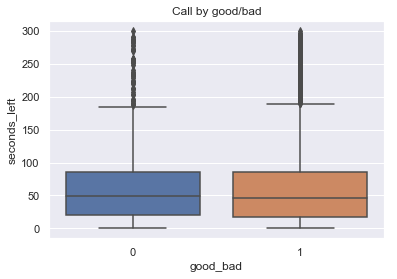

In [150]:
sns.boxplot(x="good_bad", y="seconds_left", data=df).set_title('Call by good/bad')

In [132]:
# calls by season
df.groupby('season')['review_decision'].value_counts()

season   review_decision
2014-15  CNC                 848
         CC                  625
         INC                 161
         IC                   22
2015-16  CNC                3275
         CC                 1895
         INC                 461
         IC                  101
2016-17  CNC                4007
         CC                 1504
         INC                 361
         IC                   29
2017-18  CNC                6641
         CC                 1681
         INC                 415
         IC                   55
Name: review_decision, dtype: int64

Text(0.5, 1.0, 'Call by seconds left')

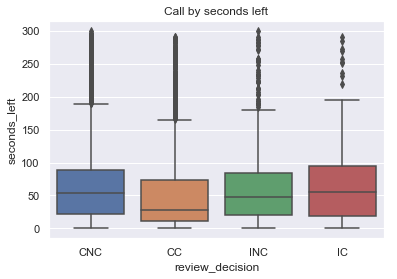

In [151]:
sns.boxplot(x="review_decision", y="seconds_left", data=df).set_title('Call by seconds left')

Text(0.5, 1.0, 'Call by Point Diff')

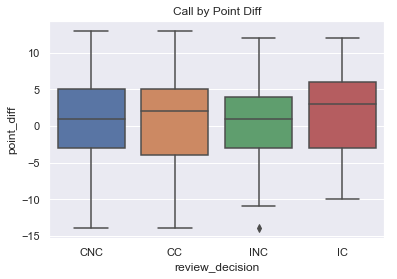

In [152]:
sns.boxplot(x="review_decision", y="point_diff", data=df).set_title('Call by Point Diff')

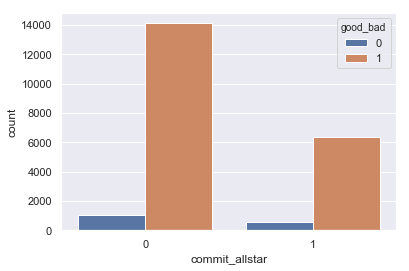

In [140]:
# calls by committing playes
sns.countplot(x="commit_allstar", hue="good_bad", data=df)

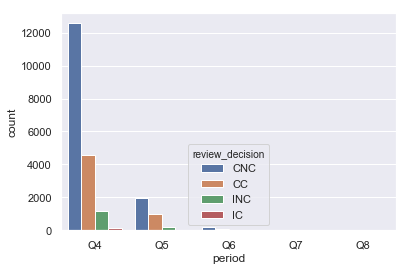

In [161]:
# calls by committing playes
sns.countplot(x="period", hue="review_decision", data=df)

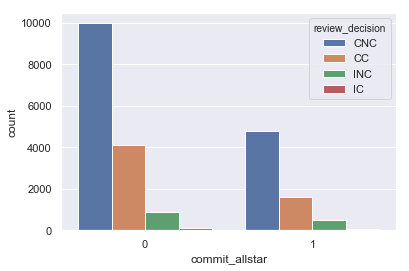

In [141]:
# calls by committing players
sns.countplot(x="commit_allstar", hue="review_decision", data=df)

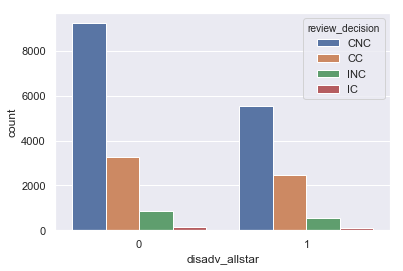

In [159]:
# calls by committing players
sns.countplot(x="disadv_allstar", hue="review_decision", data=df)

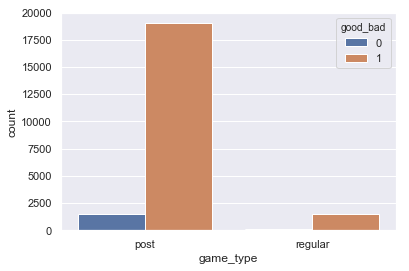

In [142]:
sns.countplot(x="game_type", hue="good_bad", data=df)

In [137]:
# calls by committing playes
df.groupby('commit_allstar')['review_decision'].value_counts()

commit_allstar  review_decision
0               CNC                9992
                CC                 4122
                INC                 907
                IC                  134
1               CNC                4779
                CC                 1583
                INC                 491
                IC                   73
Name: review_decision, dtype: int64

In [138]:
# calls by disadvantage players
df.groupby('disadv_allstar')['review_decision'].value_counts()

disadv_allstar  review_decision
0               CNC                9231
                CC                 3259
                INC                 857
                IC                  126
1               CNC                5540
                CC                 2446
                INC                 541
                IC                   81
Name: review_decision, dtype: int64

In [158]:
# calls by committing playes
plt.figure(figsize=(12,8))
sns.boxplot(x="committing_team", y="seconds_left", data=df).set_title('Call by seconds left')

TypeError: 'module' object is not callable

# Visualize Attributes 

OVER 4 SEASONS:
  Good Calls (CNC+CC) = 20476
  Bad Calls (INC+IC) = 1605
  Precentage Correct = 92.73%


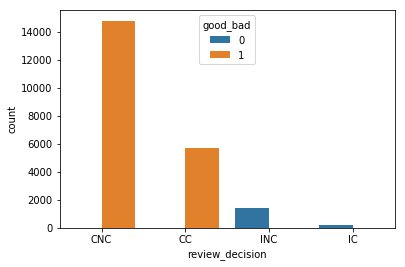

In [37]:
# Total counts from 2014/15 - 2017/18 seasons\n",
sns.countplot(x="review_decision", hue="good_bad", data=df)
good_calls = df.review_decision.value_counts()['CC']+df.review_decision.value_counts()['CNC']
bad_calls =  df.review_decision.value_counts()['IC']+df.review_decision.value_counts()['INC']
print("OVER 4 SEASONS:")
print("  Good Calls (CNC+CC) =",good_calls)
print("  Bad Calls (INC+IC) =",bad_calls)
print("  Precentage Correct = {0:.2f}%".format(100*good_calls/(good_calls+bad_calls)))

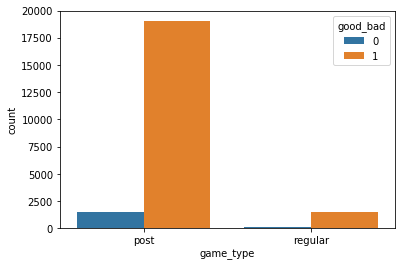

In [28]:
# histogram by regular or post season
sns.countplot(x="game_type", hue="good_bad", data=df)
#df['review_decision_code'].plot.hist(subplots=True, layout=(2,2),figsize=(10,10),bins=8)"

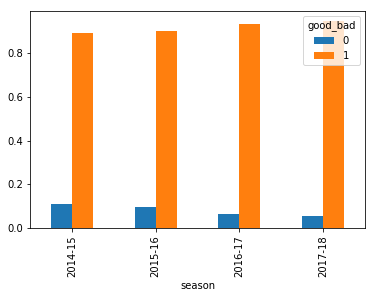

In [33]:
# histogram by season
props = df.groupby("season")['good_bad'].value_counts(normalize=True).unstack()
props.plot(kind='bar')

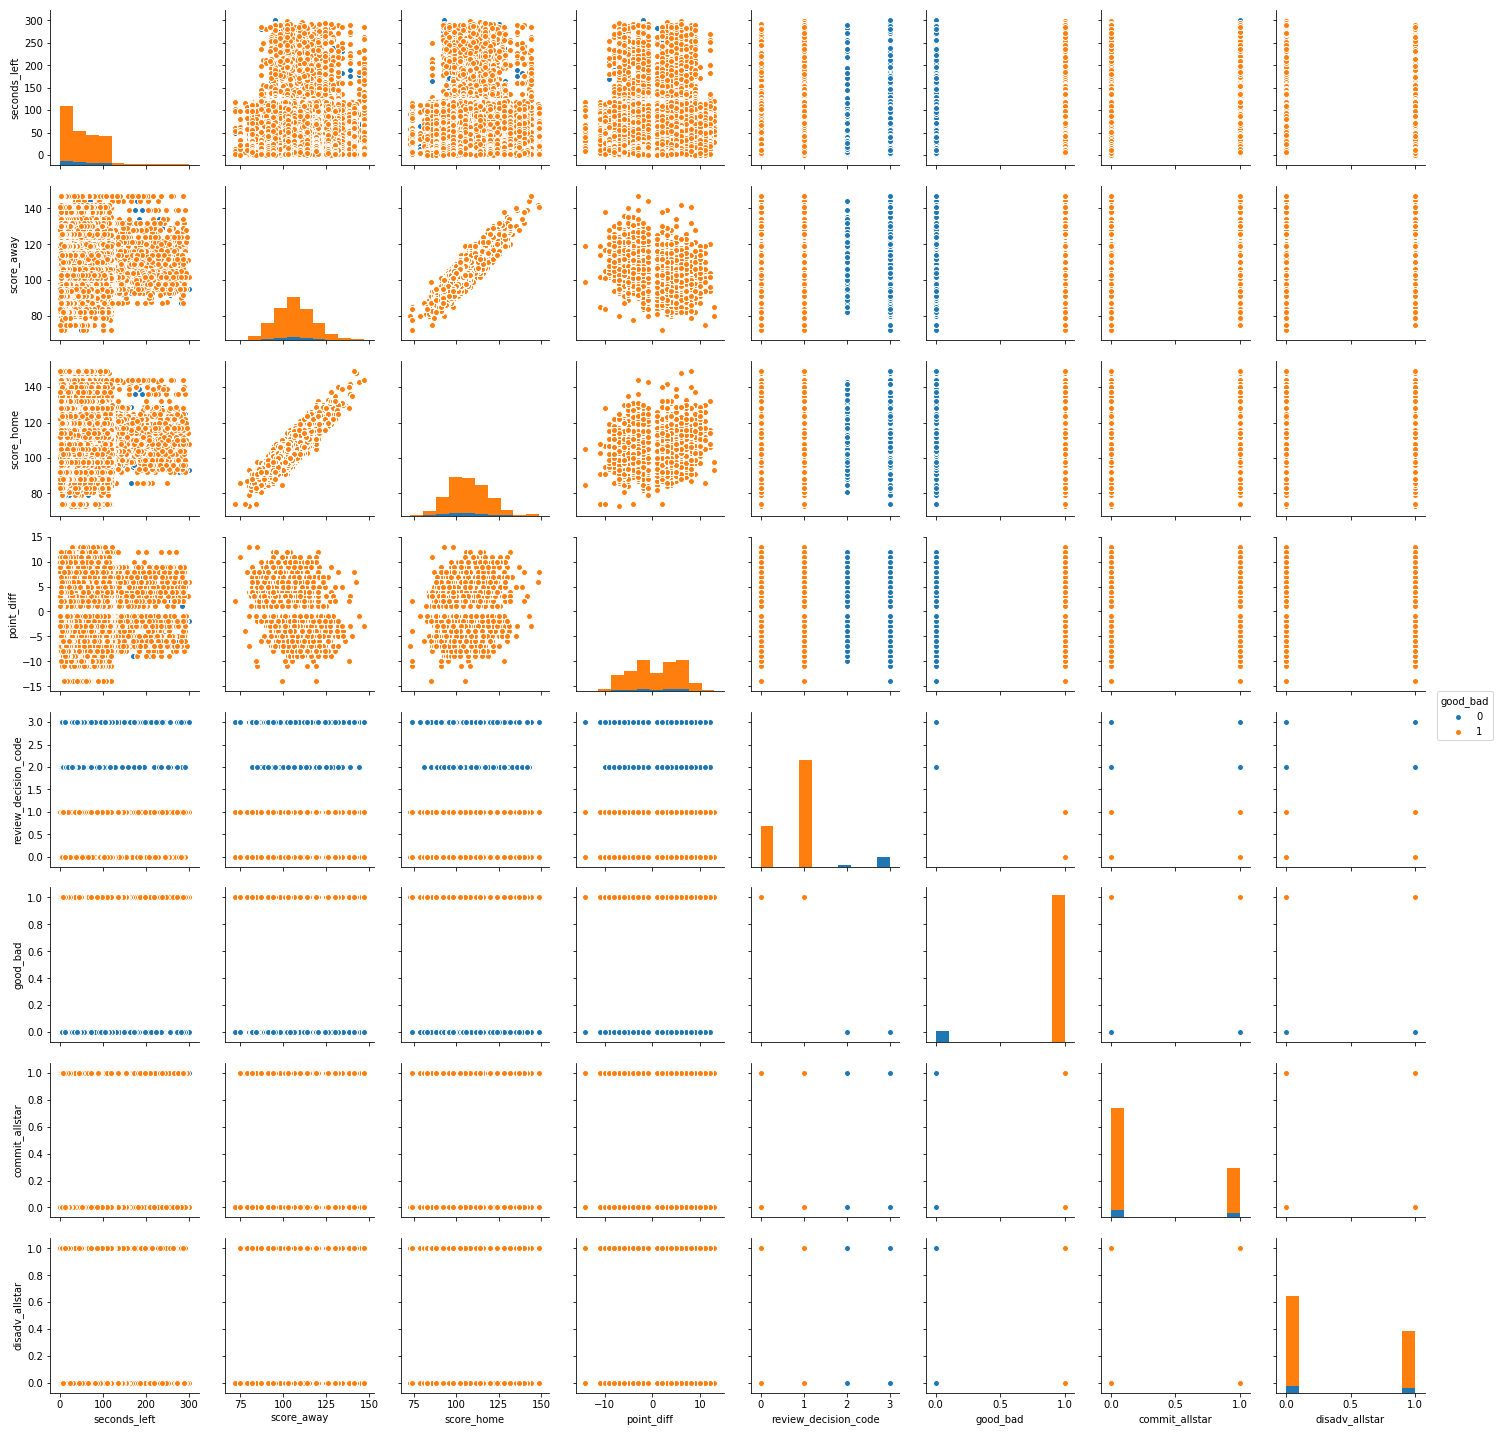

In [51]:
#g = sns.FacetGrid(df, col="season")
#g.map(sns.barplot,"review_decision","good_bad")

sns.pairplot(df,hue="good_bad")

In [52]:
from pandas import Series, DataFrame
from pylab import rcParams
import scipy
from scipy.stats import spearmanr

In [57]:
rcParams['figure.figsize'] = 5, 4
sns.set_style('whitegrid')

In [ ]:
X=df[['commit_allstar','disadv_allstar','point_diff']]

# Explore Joint Attributes and Class 

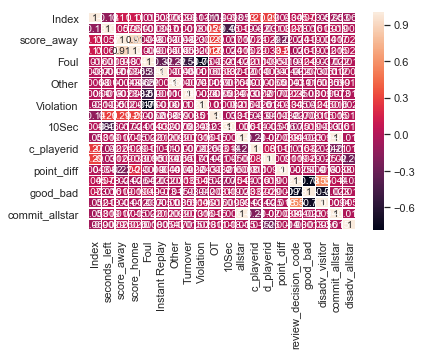

In [201]:
# Plot size of image
#MAke figure bigger plt.figure

sns.heatmap(df.corr(), annot=True, linewidth=0.5)


### NBA_api Connection Attemps

In [36]:
# Get dataframe of all players and player id's

from nba_api.stats.static import players
# get_players returns a list of dictionaries, each representing a player.
nba_players = players.get_players()

# Convert dictionary to dataframe
df_nba_players = pd.DataFrame.from_dict(nba_players)

df_nba_players.head()

,first_name,full_name,id,is_active,last_name
0,Alaa,Alaa Abdelnaby,76001,False,Abdelnaby
1,Zaid,Zaid Abdul-Aziz,76002,False,Abdul-Aziz
2,Kareem,Kareem Abdul-Jabbar,76003,False,Abdul-Jabbar
3,Mahmoud,Mahmoud Abdul-Rauf,51,False,Abdul-Rauf
4,Tariq,Tariq Abdul-Wahad,1505,False,Abdul-Wahad


In [21]:
# Create list of player id's needed to pass through endpoint 
player_id_list = df_nba_players['id'].unique().tolist()

In [38]:
# Get game specific stats with player_id and game_id

#playergamelog require playter id in api request
from nba_api.stats.endpoints import playergamelog 

nba_gamelogs = playergamelog.PlayerGameLog(player_id='203076', season='2018-19',
                                             season_type_all_star='Regular Season')

#Return dataframe
nba_gamelogs.get_data_frames()

[   SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
 0      22018     203076  0021801099  MAR 24, 2019  NOP vs. HOU  L   21    6   
 1      22018     203076  0021801056  MAR 18, 2019    NOP @ DAL  W   21    8   
 2      22018     203076  0021801036  MAR 16, 2019  NOP vs. PHX  L   22    6   
 3      22018     203076  0021801010  MAR 12, 2019  NOP vs. MIL  L   21    9   
 4      22018     203076  0021800995  MAR 10, 2019    NOP @ ATL  L   21    6   
 5      22018     203076  0021800971  MAR 06, 2019  NOP vs. UTA  L   21    6   
 6      22018     203076  0021800956  MAR 04, 2019    NOP @ UTA  W   22    7   
 7      22018     203076  0021800932  MAR 01, 2019    NOP @ PHX  W   21    7   
 8      22018     203076  0021800921  FEB 27, 2019    NOP @ LAL  L   21   10   
 9      22018     203076  0021800906  FEB 25, 2019  NOP vs. PHI  L   21    8   
 10     22018     203076  0021800874  FEB 22, 2019    NOP @ IND  L   20    6   
 11     22018     203076  0021800866  FE

### Duplicates 

In [31]:
# Which player_id should we use for duplicate records?
# Check to see which players and how many times duplicated.

print("Duplicate Summary:",
      "\nNumber of duplicate id:", df_nba_players.duplicated(['id']).sum(),
      "\nNumber of duplicate full_name:", df_nba_players.duplicated(['full_name']).sum(),
      "\nNumber of duplicate id AND full_name:", df_nba_players.duplicated(['id','full_name']).sum(),
      "\nNumber of duplicate rows:", df_nba_players.duplicated().sum())


Duplicate Summary: 
Number of duplicate id: 0 
Number of duplicate full_name: 36 
Number of duplicate id AND full_name: 0 
Number of duplicate rows: 0


In [36]:
# Create dataframe Only keep last player_id, full_name row/record

# df_nba_players_deftable_1 = df_nba_players.drop_duplicates(['full_name'], keep='last', inplace=False)

# df_nba_players_deftable_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4357 entries, 0 to 4392
Data columns (total 5 columns):
first_name    4357 non-null object
full_name     4357 non-null object
id            4357 non-null int64
is_active     4357 non-null bool
last_name     4357 non-null object
dtypes: bool(1), int64(1), object(3)
memory usage: 174.5+ KB


In [40]:
df_nba_players['full_name'].unique()

array(['Alaa Abdelnaby', 'Zaid Abdul-Aziz', 'Kareem Abdul-Jabbar', ...,
       'Bill Zopf', 'Ivica Zubac', 'Matt Zunic'], dtype=object)

In [61]:
# Need to join id to original dataframe. 
# Need to use some combination of player_id and game_id to merge individual player states for that game


#df_nba_players['full_name'].value_counts()
#df_nba_players.groupby['full_name'].value_counts()

test = df_nba_players.groupby('full_name')

print(test.filter(lambda x: x['full_name'].value_counts()>1))

     first_name         full_name       id  is_active  last_name
482         Dee         Dee Brown      244      False      Brown
483         Dee         Dee Brown   200793      False      Brown
887     Charlie     Charlie Davis    76518      False      Davis
888     Charlie     Charlie Davis    76519      False      Davis
902        Mark        Mark Davis      707      False      Davis
903        Mark        Mark Davis    76528      False      Davis
1041        Bob         Bob Duffy    76609      False      Duffy
1042        Bob         Bob Duffy    76610      False      Duffy
1051       Mike     Mike Dunleavy     2399      False   Dunleavy
1052       Mike     Mike Dunleavy    76616      False   Dunleavy
1159    Patrick     Patrick Ewing      121      False      Ewing
1160    Patrick     Patrick Ewing   201607      False      Ewing
1522       Matt       Matt Guokas    76908      False     Guokas
1523       Matt       Matt Guokas    76909      False     Guokas
1671     Cedric  Cedric H

In [52]:
#df['committing_player_v2'] = df['committing_player'].astype(str)

In [8]:
df = pd.merge(df, df_nba_players[['id']], left_on='committing_player', right_on='full_name', how='left')

KeyError: 'full_name'